# Simplified FCT Analysis

Quick analysis of Flow Completion Time (FCT) slowdown, actual FCTs, and ideal FCTs with essential statistics and CDF plots.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Simple plot style
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11


In [3]:
# Configuration - Change this to analyze different scenarios
scenario = '100_16'  # Change this to any scenario (e.g., '0_8', '99_32', etc.)
data_dir = f'/data1/lichenni/m4/testbed/eval_train/{scenario}'

# Load the data
fct_actual = np.load(os.path.join(data_dir, 'fct_topology_flows.npy'))  # Actual FCTs (ns)
fct_ideal = np.load(os.path.join(data_dir, 'fct_i_topology_flows.npy'))  # Ideal FCTs (ns)
fsize = np.load(os.path.join(data_dir, 'fsize.npy'))  # Flow sizes (bytes)
fat = np.load(os.path.join(data_dir, 'fat.npy'))  # Flow arrival times (ns)
fid=np.load(os.path.join(data_dir, 'fid_topology_flows.npy'))  # Flow IDs

index_selected=fsize>100
# index_selected=fct_actual/fct_ideal>50
# fct_actual[index_selected]=50*fct_ideal[index_selected]
# index_selected=fid>2000
# index_selected=np.logical_and(fid>0, fct_actual/fct_ideal<50)
# index_selected=fct_actual/fct_ideal<50
fct_actual=fct_actual[index_selected]
fct_ideal=fct_ideal[index_selected]
fsize=fsize[index_selected]
fat=fat[index_selected]

print(f"Loaded {len(fct_actual):,} flow records")
print(f"Flow sizes: {np.min(fsize):,} - {np.max(fsize):,} bytes")
print(f"Simulation time: {np.max(fat) / 1e9:.2f} seconds")

print(f"Analyzing scenario: {scenario}")
print(f"Loaded {len(fct_actual):,} flow records")
print(f"Flow sizes: {np.min(fsize):,} - {np.max(fsize):,} bytes")
print(f"Simulation time: {np.max(fat) / 1e9:.2f} seconds")


Loaded 1,249 flow records
Flow sizes: 102,408 - 102,408 bytes
Simulation time: 0.11 seconds
Analyzing scenario: 100_16
Loaded 1,249 flow records
Flow sizes: 102,408 - 102,408 bytes
Simulation time: 0.11 seconds


In [4]:
# Calculate slowdown and basic statistics
slowdown = fct_actual / fct_ideal
# slowdown = np.clip(slowdown, 1.0, 100.0)  # Cap between 1x and 100x

print("=== STATISTICS ===")
print(f"Slowdown: {np.mean(slowdown):.2f}x ± {np.std(slowdown):.2f}x (mean ± std)")
print(f"Median slowdown: {np.median(slowdown):.2f}x")
print(f"95th percentile slowdown: {np.percentile(slowdown, 95):.2f}x")
print(f"99th percentile slowdown: {np.percentile(slowdown, 99):.2f}x")

print(f"\nActual FCT: {np.mean(fct_actual/1e6):.2f} ± {np.std(fct_actual/1e6):.2f} ms")
print(f"Ideal FCT: {np.mean(fct_ideal/1e6):.2f} ± {np.std(fct_ideal/1e6):.2f} ms")


=== STATISTICS ===
Slowdown: 12.93x ± 7.15x (mean ± std)
Median slowdown: 12.32x
95th percentile slowdown: 26.06x
99th percentile slowdown: 29.99x

Actual FCT: 1.29 ± 0.71 ms
Ideal FCT: 0.10 ± 0.01 ms


In [5]:
# Calculate and plot number of active flows over time
def calculate_active_flows(start_times, completion_times, time_resolution_ms=1):
    """
    Calculate number of active flows over time
    
    Args:
        start_times: Flow start times (ns)
        completion_times: Flow completion times (ns) 
        time_resolution_ms: Time resolution in milliseconds for the timeline
    
    Returns:
        timeline: Time points (seconds)
        active_counts: Number of active flows at each time point
    """
    # Convert to seconds for easier handling
    start_times_s = start_times / 1e9
    completion_times_s = completion_times / 1e9
    
    # Create timeline from 0 to max completion time
    max_time = np.max(completion_times_s)
    timeline = np.arange(0, max_time + time_resolution_ms/1000, time_resolution_ms/1000)
    
    # Count active flows at each time point
    active_counts = np.zeros(len(timeline))
    
    for i, t in enumerate(timeline):
        # Flows that have started but not yet completed
        active_mask = (start_times_s <= t) & (completion_times_s > t)
        active_counts[i] = np.sum(active_mask)
    
    return timeline, active_counts

# Calculate flow completion times
flow_start_times = fat  # Flow arrival times
flow_completion_times = fat + fct_actual  # Arrival time + actual FCT

print("Calculating active flows timeline...")
timeline, active_counts = calculate_active_flows(flow_start_times, flow_completion_times, time_resolution_ms=10)

print(f"Max concurrent flows: {int(np.max(active_counts)):,}")
print(f"Average concurrent flows: {np.mean(active_counts):.1f}")
print(f"Timeline spans: {timeline[-1]:.2f} seconds")


Calculating active flows timeline...
Max concurrent flows: 30
Average concurrent flows: 12.2
Timeline spans: 0.12 seconds


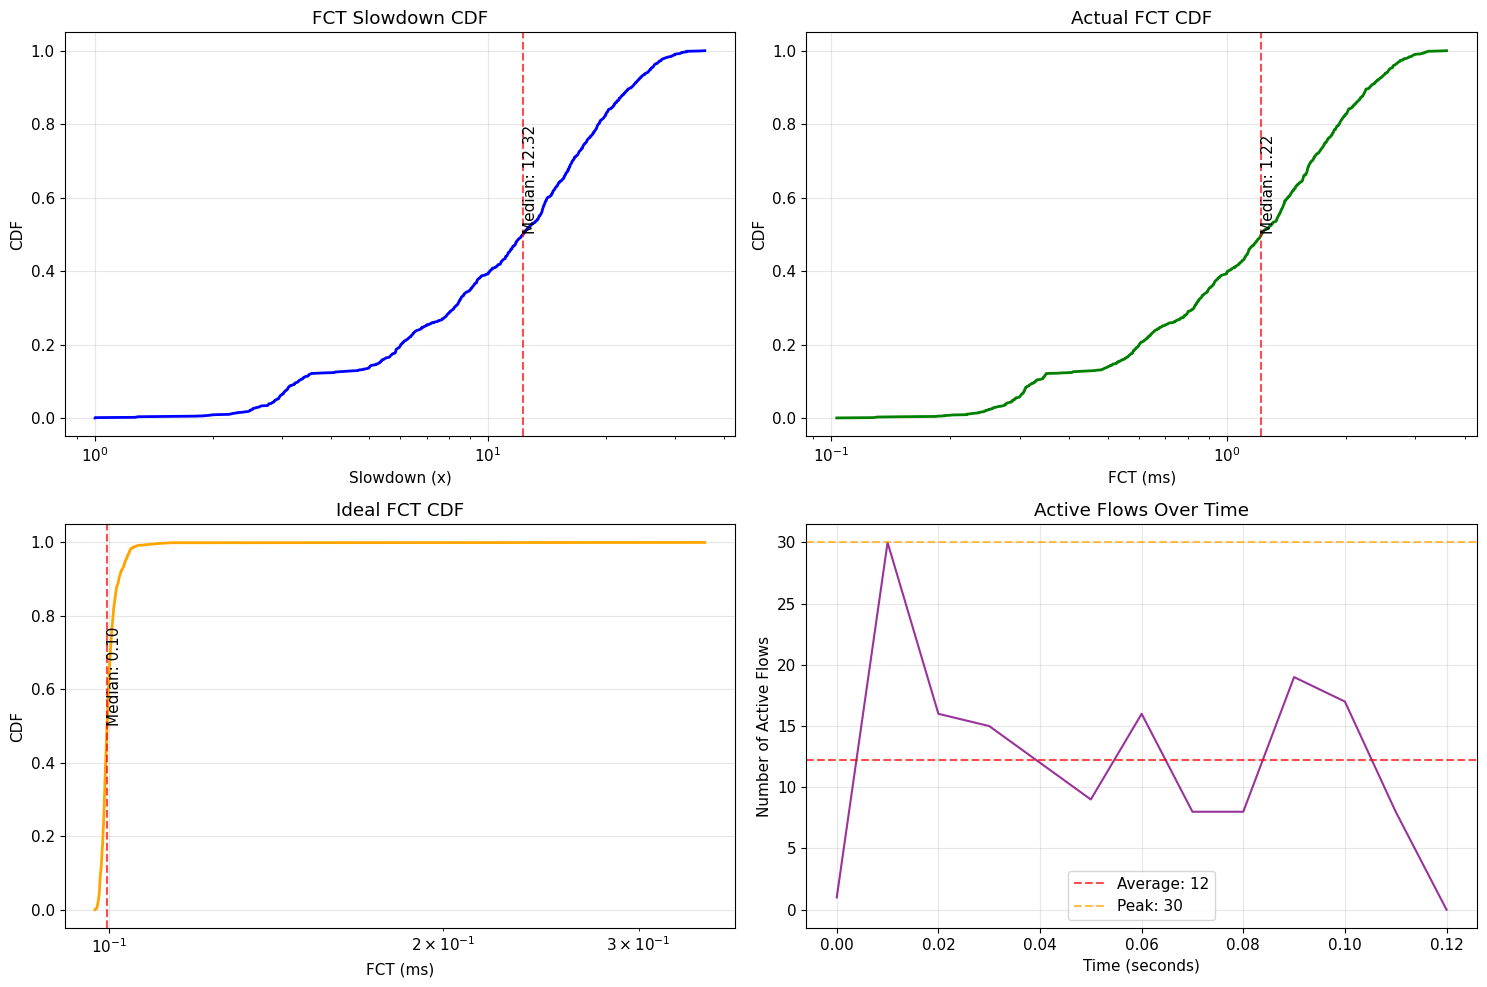

In [6]:
# Plot CDFs for Slowdown, Actual FCTs, Ideal FCTs, and Active Flows Timeline
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

def plot_cdf(data, ax, title, xlabel, color='blue',log_switch=False):
    """Helper function to plot CDF"""
    sorted_data = np.sort(data)
    cdf_y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax.plot(sorted_data, cdf_y, linewidth=2, color=color)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('CDF')
    ax.set_title(title)
    if log_switch:
        ax.set_xscale('log')
    ax.grid(True, alpha=0.3)
    
    # Add median line
    median_val = np.median(data)
    ax.axvline(median_val, color='red', linestyle='--', alpha=0.7)
    ax.text(median_val, 0.5, f'Median: {median_val:.2f}', 
            rotation=90, verticalalignment='bottom')

# Plot 1: Slowdown CDF
plot_cdf(slowdown, axes[0,0], 'FCT Slowdown CDF', 'Slowdown (x)', 'blue',log_switch=True)
# axes[0,0].set_xlim(left=1.0,log_switch=True)

# Plot 2: Actual FCT CDF
plot_cdf(fct_actual/1e6, axes[0,1], 'Actual FCT CDF', 'FCT (ms)', 'green',log_switch=True)

# Plot 3: Ideal FCT CDF
plot_cdf(fct_ideal/1e6, axes[1,0], 'Ideal FCT CDF', 'FCT (ms)', 'orange',log_switch=True)

# Plot 4: Active Flows Timeline
axes[1,1].plot(timeline, active_counts, linewidth=1.5, color='purple', alpha=0.8)
axes[1,1].set_xlabel('Time (seconds)')
axes[1,1].set_ylabel('Number of Active Flows')
axes[1,1].set_title('Active Flows Over Time')
axes[1,1].grid(True, alpha=0.3)

# Add statistics to active flows plot
max_flows = int(np.max(active_counts))
avg_flows = np.mean(active_counts)
axes[1,1].axhline(avg_flows, color='red', linestyle='--', alpha=0.7, label=f'Average: {avg_flows:.0f}')
axes[1,1].axhline(max_flows, color='orange', linestyle='--', alpha=0.7, label=f'Peak: {max_flows:,}')
axes[1,1].legend()

plt.tight_layout()
plt.savefig(f'/data1/lichenni/m4/testbed/fct_analysis_{scenario}.png', dpi=300, bbox_inches='tight')
plt.show()


Loaded 3 busy periods
Total flows: 2486
Busy period statistics:
Total busy periods: 3
Total busy periods single: 0, []
Total busy periods non-single: 3, [(0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 34, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 102, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 165, 166, 167, 168, 169, 171, 172, 173, 174, 176, 177, 178, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 217, 221, 222, 224, 225, 226, 227, 228, 229, 230, 231, 232, 234, 235, 236, 237, 238, 240, 241, 242, 243, 244, 272, 274, 275, 276, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 296, 297, 298, 299, 301, 302, 303, 304, 305, 306, 307, 310, 336, 340, 341, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 3

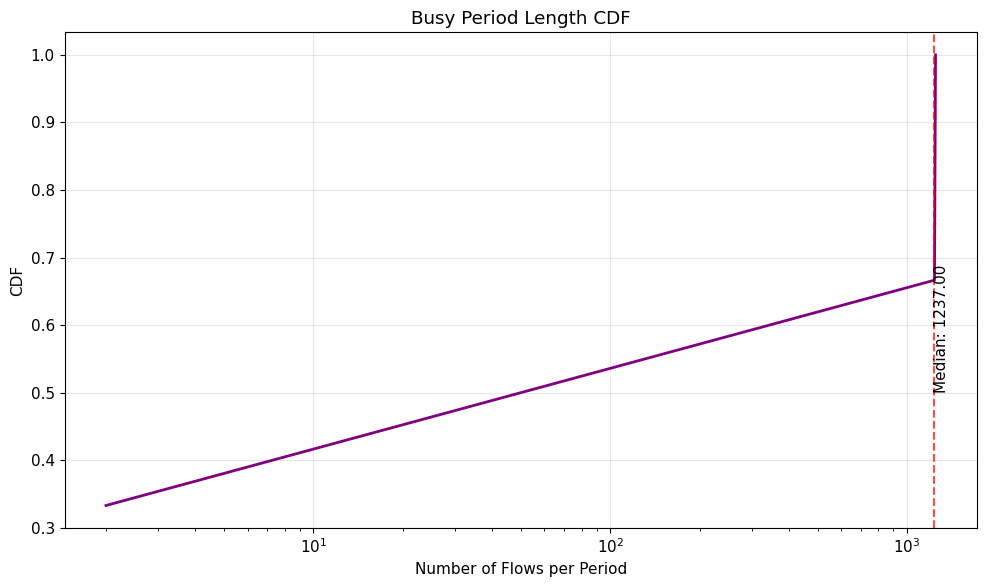

In [8]:
# Load busy periods for the current scenario
try:
    busy_periods = np.load(os.path.join(f"/data1/lichenni/m4/testbed/eval_train/{scenario}", 'period_topology_flows_t100000000.npy'), allow_pickle=True)
    print(f"Loaded {len(busy_periods)} busy periods")
    
    # Calculate data length (number of flows per busy period)
    data_length = [len(period) for period in busy_periods]
    sum_data_length = np.sum(data_length)
    print(f"Total flows: {sum_data_length}")
    
    # Create figure and plot CDF
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    plot_cdf(data_length, ax, "Busy Period Length CDF", "Number of Flows per Period", 'purple',log_switch=True)
    
    # Add statistics
    print(f"Busy period statistics:")
    busy_periods_non_single = [period for period in busy_periods if len(period) > 1]
    busy_periods_single = [period for period in busy_periods if len(period) == 1]
    print(f"Total busy periods: {len(busy_periods)}")
    print(f"Total busy periods single: {len(busy_periods_single)}, {busy_periods_single[:10]}")
    print(f"Total busy periods non-single: {len(busy_periods_non_single)}, {busy_periods_non_single}")
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print(f"ERROR: Busy periods file not found for scenario {scenario}")
    print(f"Looking for: {os.path.join(data_dir, 'period_topology_flows_t100000000.npy')}")
    print("Make sure you've run the data processing script first (run_m4_post.py)")
except Exception as e:
    print(f"Error loading busy periods: {e}")